# Chapter 6. Phase retrieval

## 6.1 The autocorrelation

A diffraction pattern contains information about the intensities of the molecular transform but lacks information about the phases. If we Fourier transform the diffraction intensities, we end up with the *autocorrelation* of the electron density,

$$
\rho * \rho = \mathcal{F}^{-1} \{ |F|^2 \}
$$

The autocorrelation, called the Patterson function among crystallographers, is similar to the convolution of the electron density with itself.

Calculate the autocorrelation of the caffeine molecule as follows:

In [1]:
%%capture
# Suppress warning output when importing matplotlib.
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["figure.figsize"] = (8, 6)
from IPython.display import HTML

In [2]:
# add path to the Modules
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

In [3]:
from Projection import *

In [4]:
caf = Molecule('caffeine.pdb')

- Calculate the molecular transform of caffeine out to a resolution of 0.2 $\overset{\circ}{\text{A}}$. Use a sampling distance of 1/16.

In [5]:
H, K, L = TwoD_grid(1./16, 5)
F = moltrans(caf, H,K,L)

- Calculate the intensities of the molecular transform.

In [6]:
ints = abs(F)**2

- Calculate the autocorrelation from the intensities.

In [7]:
auto = fft.fftshift(abs(fft.ifftn(ints, [2**10, 2**10])))

Plot the autocorrelation with **imshow(auto)**. Also calculate the electron density (by Fourier transforming the molecular transform) and plot that in another window. You should see that the autocorrelation is larger than electron density and that it is symmetric around the origin. In fact, the autocorrelation is non-zero in an area that is twice the area in which electron density is non-zero. Based on this, why did you use a sampling step size of 1/16 instead of 1/8?

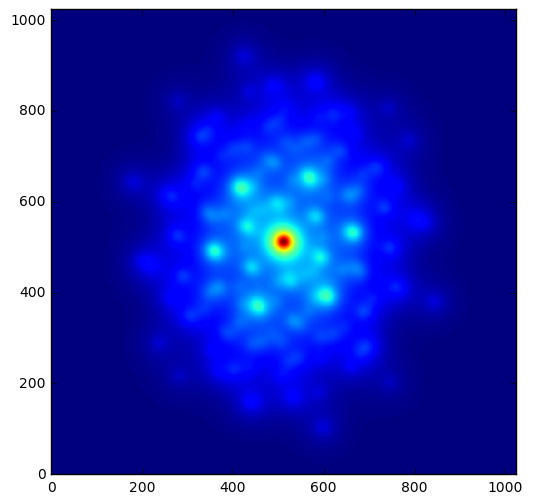

In [8]:
plt.imshow(auto, interpolation='none',origin='lower')

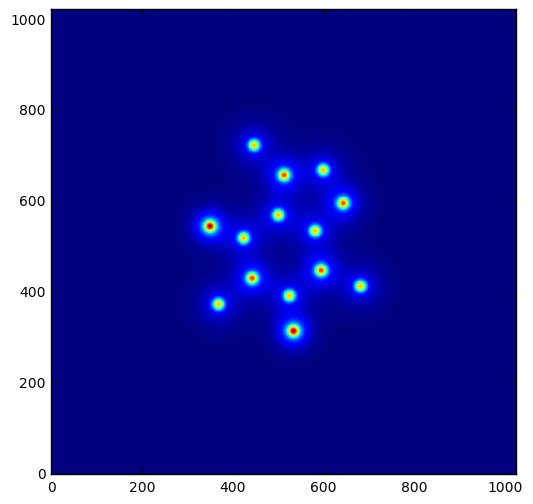

In [9]:
rho = fft.fftshift(abs(fft.ifftn(F, [2**10, 2**10])))
plt.imshow(rho, interpolation='none',origin='lower')

## 6.2 Phasing using oversampling

In the previous section we saw that different sampling rates of the molecular transform puts the electron density into periodic boxes of different sizes. A sampling rate that is just high enough to allow the density to sit in its box without overlapping with adjacant boxes is referred to as critical sampling. Any sampling finer than critical sampling is called oversampling and will result in a box that is larger than the electron density.

If we have a suffciently oversampled diffraction pattern and an estimate of the size of the molecule (a low-resolution image or even the autocorrelation), we can use the fact that the box is larger than the molecule to calculate the phases of the diffraction pattern. Any point that is outside the support of the molecule (the support is essentially the area of the box that contains electron density) should have a value of zero since there is no density there. The correct phases should be those that lead to an electron density that is zero everywhere outside the support. The higher the sampling rate, the further the box extends outside the molecule, and the more zero-valued points are available to use as constraints on the phases. We can also use other information that we may have, such as the positivity of the electron density.

### 6.2.1 The error-reduction algorithm

In this exercise, you will try to find the phases of an oversampled diffraction pattern of caffeine using a fairly simple iterative method.

Start by loading an oversampled diffraction pattern file **diffCaff48.npy**, which contains a set of diffraction intensities. Then load the file **suppCaff48.npy** to get an estimate of the support of the molecule, which basically contains an outline of the caffeine molecule. Take a look at these variables with **imshow()** and make sure that you understand what they represent.

In [10]:
ints = np.load(os.path.join(os.getcwd(), '..', 'data', 'diffCaff48.npy'))
support = np.load(os.path.join(os.getcwd(), '..', 'data', 'suppCaff48.npy'))

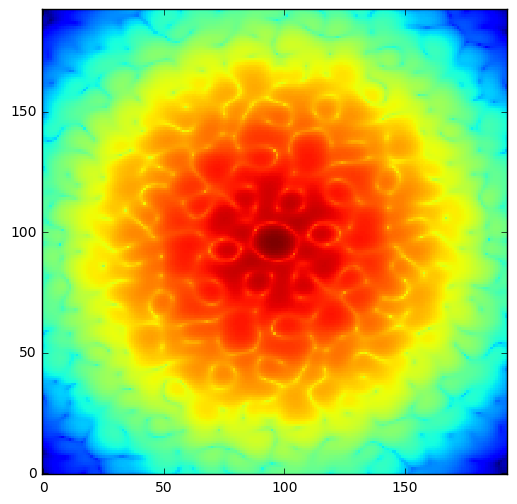

In [11]:
plt.imshow(np.log(ints), interpolation='none',origin='lower')

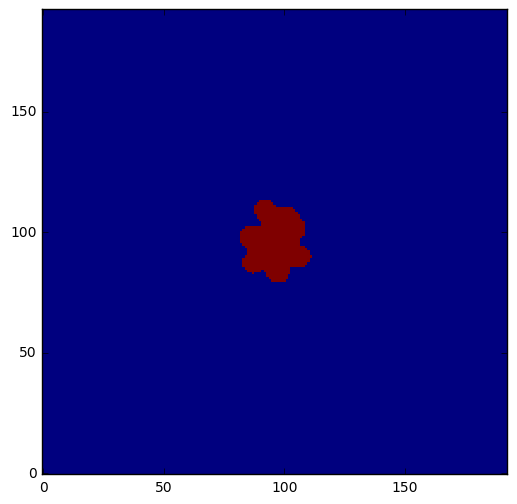

In [12]:
plt.imshow(support, interpolation='none',origin='lower')

**Initial preparations** &nbsp; &nbsp; Create an initial estimate of the electron density by adding random density within support of the molecule,

In [13]:
rho = support * np.random.rand(ints.shape[0], ints.shape[1])

Calculate the amplitudes of the molecular transform as

In [14]:
amplitudes = np.sqrt(ints)

Finally, **ifftshift** the variables **amplitudes**, **support** and **rho**. By doing this, you transform the variables into the form that the FFT expects them to have, and you avoid having to use **fftshift** and **ifftshift** repeatedly within the loop.

In [15]:
rho = fft.ifftshift(rho)
amplitudes = fft.ifftshift(amplitudes)
support = fft.ifftshift(support)

**Iterative algorithm** &nbsp; &nbsp; Implement the following algorithm within a loop:

1. Fourier transform your density estimate to obtain an estimate of the molecular transform.
2. Keep the phases of the molecular transform, but replace the amplitudes with the measured diffraction amplitudes (the square root of the diffraction intensities). This is referred to as applying *Fourier space constraints*.
3. Inverse Fourier transform to obtain a new estimate of the electron density.
4. Set everything outside the support, and all negative values within the support, to zero. This is referred to as applying *real space constraints*.
5. Iterate points 1-4.

Save the image of electron density after each iteration and show them as a movie. This allows us to follow the evolution of the algorithm in real time. Try this algorithm for various number of iterations.

In [16]:
%%capture
fig = plt.figure()

n_iter = 100

ims = []

for k in range(n_iter):
    F = fft.fft2(rho) # step 1
    phases = np.angle(F) # step 2
    F = amplitudes * np.exp(1j * phases) # step 2
    rho = fft.ifft2(F) # step 3
    rho = rho * support # step 4
    rho[rho<0] = 0 # step 4
    im = plt.imshow(np.real(fft.fftshift(rho)), interpolation='none',origin='lower', animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)

In [17]:
HTML(ani.to_html5_video())

## 6.3 The hybrid input-output algorithm

The previous algorithm tends to converge very slowly, sometimes requiring tens of thousands of iterations to reach an accurate result. Fortunately, a clever modification of the density in each iteration can speed up the convergence significantly.

The basic algorithm iterates from real space to Fourier space and back to real space

\begin{align}
F_k &= \mathcal{F} (\rho_k) \\
F_k'&= \text{constrain} (F_k) \quad \text{Apply Fourier space constraints} \\
\rho_k' &= \mathcal{F}^{-1} (F_k') \\
\rho_{k+1} &= \text{constrain} (\rho_k') \quad \text{Apply real space constraints}
\end{align}

We will now modify the last step of the algorithm as follows

\begin{equation}
\rho_{k+1} = \left \{
\begin{array}{ll}
\rho_k' & \text{where $\rho_k'$ satisfies the constraints} \\
\rho_k - \beta \rho_k' & \text{where $\rho_k'$ does not satisfies the constraints}
\end{array}
\right.
\end{equation}

Here $\beta$ is a constant that will affect the convergence and stability of the algorithm. Typically $0<\beta<1$.

To implement the above, you must do two things.

- Find all points in $\rho_k'$ that violate the real space constraints. You can figure out how to do this yourself, or use the function **violidx = getviolations(rho2,support)**

- Set the violating points to their new values. If $\rho_k$ = rho1, $\rho_k'$ = rho2 and $\rho_{k+1}$ = rho3, then **rho3 = rho2** and **rho3(violidx) = rho1(violidx) - beta*rho2(violidx)**.

You should also monitor the error of the reconstruction; to do this add the following line after step three of the algorithm:

~~~~
E(k) = sum(sum(abs(rho2(violidx))**2))
~~~~

Here **k** stands for the iteration index. Before your loop, you should initialize this variable with the command **E = np.zeros((numberOfIterations, 1))**,where **numberOfIterations** stands for the total number iterations in your loop. Now try the reconstruction from the previous exercise. Look at the output and plot the error for different number of iterations.

In [18]:
%%capture
fig = plt.figure()

n_iter = 100

beta = 0.2

rho1 = support * np.random.rand(ints.shape[0], ints.shape[1])

ims = []
E = np.zeros((n_iter, 1))

for k in range(n_iter):
    F = fft.fft2(rho1)
    phases = np.angle(F)
    F = amplitudes * np.exp(1j * phases)
    rho2 = fft.ifft2(F)
    rho3 = rho2
    violidx = getviolations(rho2, support)
    E[k] = sum(abs(rho2[violidx])**2)
    rho3[violidx] = rho1[violidx] - beta*rho2[violidx]
    rho1 = rho3
    im = plt.imshow(np.real(fft.fftshift(rho1)), interpolation='none',origin='lower', animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)

In [19]:
HTML(ani.to_html5_video())

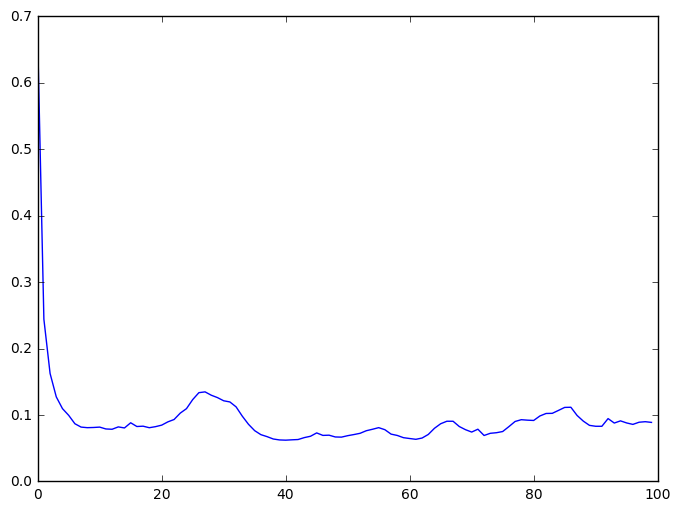

In [20]:
plt.plot(E)

Next, try the reconstruction using *only the autocorrelation* as your support. Instead of loading the support in **suppCaff48**, create the support as

~~~~
support = auto > 0.1*max(auto(:))
~~~~

Does the algorithm still converge? Why is it useful to have an algorithm that converges with the autocorrelation of the density as a support?

In [21]:
%%capture
fig = plt.figure()

n_iter = 100

beta = 0.2

auto = abs(fft.ifftn(ints))

support = np.zeros_like(auto)
support[np.where(auto>0.1*auto.max())] = 1

rho1 = support * np.random.rand(ints.shape[0], ints.shape[1])

ims = []
E = np.zeros((n_iter, 1))

for k in range(n_iter):
    F = fft.fft2(rho1)
    phases = np.angle(F)
    F = amplitudes * np.exp(1j * phases)
    rho2 = fft.ifft2(F)
    rho3 = rho2
    violidx = getviolations(rho2, support)
    E[k] = sum(abs(rho2[violidx])**2)
    rho3[violidx] = rho1[violidx] - beta*rho2[violidx]
    rho1 = rho3
    im = plt.imshow(np.real(fft.fftshift(rho1)), interpolation='none',origin='lower', animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)

In [22]:
HTML(ani.to_html5_video())

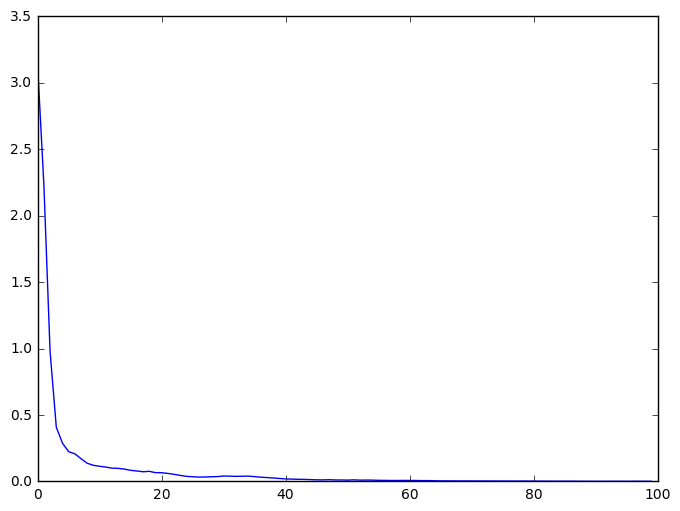

In [23]:
plt.plot(E)